# Time series example using RNN
 V02 predict simultaneously all the forecasts days (2 weeks)
 
 Results
 - 5 Years hitorical data (300 days to test) - X_lenght: 20 weeks. LSTM size? --> (RMSE trn / RMSE test)
   - 512 --> 9 / 14
   - 256 --> 7 / 5
   - 128 --> 9 / 4
   - 64  --> 7 / 4.4 (this)
   - 32  --> 12 / 15
   
 - Years: 5 - LSTM: 64. X_lenght?
   - 20w --> 7 / 4.4
   - 10w --> 8 / 8
   - 5w  --> 7.6 / 7.4 (this)
   - 4w  --> 8.9 / 10.4
   - 2w  --> 13 / 23
   
 - weeks: 5 - LSTM 64. Years?
   - 5y  --> 7.6 / 7.4
   - 3y  --> 18 / 35
   - 7y  --> 5 / 6
   - 10y --> 2.7 / 2.7 (this)
 - Dropout over the last
   - 1 --> 2.7 / 2.7 (this)
   - 0.8 --> 3.8 / 3.7
   - 0.5 --> 7.2 / 2.5

In [1]:
from __future__ import print_function

import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10) 


path='/tmp/'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8827150380433563071
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11990125773
locality {
  bus_id: 1
}
incarnation: 7146107653333245554
physical_device_desc: "device: 0, name: TITAN X (Pascal), pci bus id: 0000:06:00.0"
]


In [3]:
# Generate seasonal data dataframe
n_cases = 365*10

data=[]
for i in range(n_cases):
    t = (i/100.)
    s = abs((i%7)-3.5)*2.
    data += list(t + s + np.random.randn(1))

index = pd.date_range('1/1/2000', periods=n_cases)
serie = pd.Series(data=data, index=index, name='value')
serie.head


<bound method NDFrame.head of 2000-01-01     6.933219
2000-01-02     5.973465
2000-01-03     3.400967
2000-01-04    -0.089347
2000-01-05     0.984660
2000-01-06     2.444031
2000-01-07     3.620217
2000-01-08     7.375924
2000-01-09     7.267787
2000-01-10     2.457103
2000-01-11     1.576247
2000-01-12     0.849084
2000-01-13     3.684267
2000-01-14     5.411116
2000-01-15     5.198845
2000-01-16     5.357984
2000-01-17     3.119263
2000-01-18     1.490629
2000-01-19     1.673005
2000-01-20     2.857419
2000-01-21     6.250595
2000-01-22     8.215384
2000-01-23     5.997771
2000-01-24     2.121417
2000-01-25     0.621431
2000-01-26     1.790159
2000-01-27     1.085199
2000-01-28     6.451253
2000-01-29     6.660117
2000-01-30     6.210442
                ...    
2009-11-29    41.678087
2009-11-30    39.112183
2009-12-01    37.380580
2009-12-02    36.997089
2009-12-03    40.675834
2009-12-04    41.347727
2009-12-05    43.847577
2009-12-06    42.262766
2009-12-07    39.561733
2009-12-08

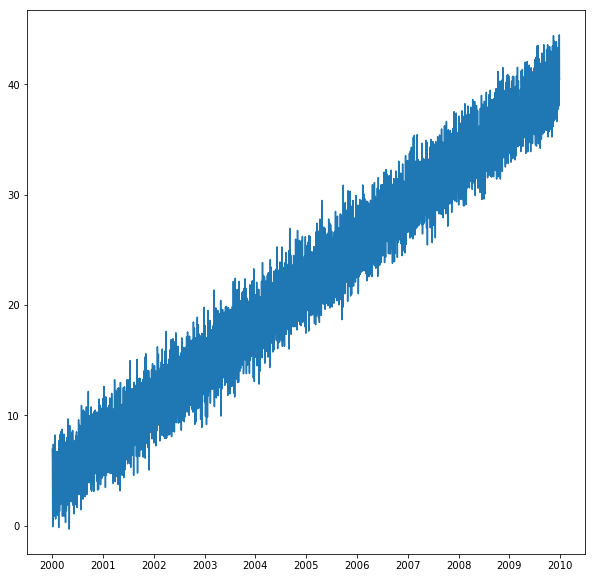

In [4]:
plt.plot(serie)

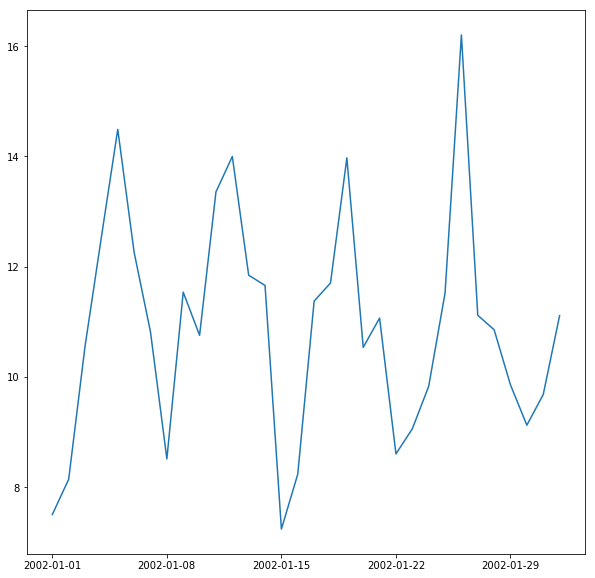

In [5]:
plt.plot(serie['1/1/2002':'2/1/2002'])

In [6]:
def extract_sequences(serie_np, maxlen=14, maxlen_y=14, step=1):
    '''
    Cut the serie in redundant sequences of maxlen data
    One sequence of length 14 for each day
    '''
    n_cases = (serie_np.shape[0] - maxlen - maxlen_y) // step
    sequences = np.empty((n_cases, maxlen))
    next_data = np.empty((n_cases, maxlen_y))
    for i in range(0, serie_np.shape[0] - maxlen - maxlen_y, step): 
        sequences[i] = serie_np[i : i + maxlen]
        next_data[i] = serie_np[i + maxlen : i + maxlen + maxlen_y]
    return sequences, next_data
#X_trn , y_trn  = extract_sequences(seqs, maxlen=14*24, step=1)

In [7]:
# Extract sequences
maxlen = 35 # 20 weeks
maxlen_y = 14

X_trn , y_trn  = extract_sequences(serie.as_matrix()[:n_cases-300], maxlen=maxlen, maxlen_y=maxlen_y, step=1)
X_tst , y_tst  = extract_sequences(serie.as_matrix()[n_cases-300:], maxlen=maxlen, maxlen_y=maxlen_y, step=1)
print(X_trn.shape, y_trn.shape)
print(X_tst.shape, y_tst.shape)
print(y_tst[0])




(3301, 35) (3301, 14)
(251, 35) (251, 14)
[ 34.36656078  37.36038713  37.04112894  39.56499897  35.42308422
  36.34027951  35.10874963  35.90188477  36.65354535  40.27006737
  40.68798169  39.31076839  35.93288054  36.32476107]


In [8]:
# Normalize
range_trn = np.max(X_trn) - np.min(X_trn)
print(range_trn)
X_trn = (X_trn / range_trn) -0.5
y_trn = (y_trn / range_trn) -0.5
X_tst = (X_tst / range_trn) -0.5
y_tst = (y_tst / range_trn) -0.5

41.7868466437


In [9]:
def generate_batch(X, y, batch_size=4, limit=-1, shuffle_data=True):
    ''' 
    Generate batches for one epoch
    Randomize order for each epoch
    '''
    shuffle_index = [i for i in range(0, X.shape[0], batch_size)]
    if shuffle_data:
        from random import shuffle
        shuffle(shuffle_index)
    
    for i in shuffle_index[:limit]:
        yield X[i:i+batch_size], y[i:i+batch_size]
        
gb = generate_batch(X_trn, y_trn)
print(next(gb))

(array([[ 0.2698312 ,  0.27593019,  0.31596469,  0.39034899,  0.44734598,
         0.33877118,  0.31624017,  0.3038587 ,  0.25142501,  0.32142155,
         0.3837614 ,  0.4254608 ,  0.41920988,  0.32211521,  0.29960557,
         0.27349731,  0.31637399,  0.37173979,  0.48451559,  0.40517463,
         0.33905525,  0.28297744,  0.25660768,  0.37820664,  0.37805881,
         0.43703928,  0.36906804,  0.34827064,  0.25880326,  0.27344299,
         0.31845629,  0.38918182,  0.46384072,  0.39613151,  0.35156161],
       [ 0.27593019,  0.31596469,  0.39034899,  0.44734598,  0.33877118,
         0.31624017,  0.3038587 ,  0.25142501,  0.32142155,  0.3837614 ,
         0.4254608 ,  0.41920988,  0.32211521,  0.29960557,  0.27349731,
         0.31637399,  0.37173979,  0.48451559,  0.40517463,  0.33905525,
         0.28297744,  0.25660768,  0.37820664,  0.37805881,  0.43703928,
         0.36906804,  0.34827064,  0.25880326,  0.27344299,  0.31845629,
         0.38918182,  0.46384072,  0.39613151,  0

## Basic rnn model over original serie

In [10]:
gpu_options = tf.GPUOptions(allow_growth = True)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options, log_device_placement=True))


In [11]:
def dense(x, input_size=10, otput_size=1):
    W = tf.Variable(tf.truncated_normal([input_size, otput_size], stddev=0.1))
    b = tf.Variable(tf.constant(0.1, shape=[otput_size]))
    return tf.matmul(x,W) + b

In [12]:
# Parameters

#features = 1
lstm_feat = 64

#Inputs
x_input = tf.placeholder(tf.float32, shape=[None, maxlen], name='x')
x_input_lstm = tf.reshape(x_input, [-1,maxlen, 1])
y_input = tf.placeholder(tf.float32, shape=[None, maxlen_y], name='y')

# Recurrent layer
#lstm1 = tf.nn.rnn_cell.BasicLSTMCell(lstm_feat)
keep_prob = tf.placeholder(tf.float32, name='keep_prob')
lstm1 = tf.contrib.rnn.LSTMCell(lstm_feat, initializer=tf.random_uniform_initializer(-0.1, 0.1, seed=123))
lstm1 = tf.contrib.rnn.DropoutWrapper(lstm1, output_keep_prob=keep_prob)
lstm_out, _ = tf.nn.dynamic_rnn(lstm1, x_input_lstm, dtype=tf.float32, scope='lstm04')

#Final dense layer
y_pred = dense(lstm_out[:,-1,:], input_size=lstm_feat, otput_size=maxlen_y)
print(y_pred)



Tensor("add:0", shape=(?, 14), dtype=float32)


In [13]:
#y_pred  = tf.reshape(dense_out,[-1])
#print(y_pred)

# Loss function
cost  = tf.reduce_sum(tf.square(y_pred - y_input))

# Trainer
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
train_step = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

In [23]:
sess.run(tf.global_variables_initializer())

In [24]:
# Train graph
num_epoch=400
batchSize=256

i=0
lr=0.001
for epoch in range(num_epoch):
    c_trn = []
    gb = generate_batch(X_trn, y_trn, batch_size=batchSize)
    for x_b, y_b in gb:
        feed_dict={x_input: x_b, y_input: y_b, learning_rate: lr, keep_prob: 0.9}
        _, c = sess.run([train_step, cost], feed_dict=feed_dict)
        c_trn += [c]
    i += 1
    if i%10==0:
        c_tst = cost.eval(feed_dict={x_input: X_tst, y_input: y_tst, keep_prob: 1})   
        print('Epoch: ', epoch, ' - LR: ',lr, ' - Cost: ',np.mean(c_trn, axis=0), ' - Cost test: ',c_tst )
    #lr *= 0.99

Epoch:  9  - LR:  0.001  - Cost:  16.6841  - Cost test:  14.7493
Epoch:  19  - LR:  0.001  - Cost:  18.0051  - Cost test:  20.6613
Epoch:  29  - LR:  0.001  - Cost:  24.0317  - Cost test:  14.7915
Epoch:  39  - LR:  0.001  - Cost:  13.2926  - Cost test:  10.3036
Epoch:  49  - LR:  0.001  - Cost:  15.4532  - Cost test:  13.4217
Epoch:  59  - LR:  0.001  - Cost:  12.2682  - Cost test:  10.0283
Epoch:  69  - LR:  0.001  - Cost:  9.6993  - Cost test:  8.93372
Epoch:  79  - LR:  0.001  - Cost:  6.01225  - Cost test:  10.5357
Epoch:  89  - LR:  0.001  - Cost:  5.66718  - Cost test:  10.2711
Epoch:  99  - LR:  0.001  - Cost:  3.90152  - Cost test:  3.19416
Epoch:  109  - LR:  0.001  - Cost:  4.08175  - Cost test:  2.55082
Epoch:  119  - LR:  0.001  - Cost:  4.54871  - Cost test:  4.64547
Epoch:  129  - LR:  0.001  - Cost:  3.65478  - Cost test:  5.27362
Epoch:  139  - LR:  0.001  - Cost:  3.96295  - Cost test:  2.82841
Epoch:  149  - LR:  0.001  - Cost:  3.91322  - Cost test:  2.60515
Epoch: 

[[ 0.46411219  0.44306025  0.39179456  0.34861684  0.34696218  0.38761097
   0.43872857  0.46573073  0.44588724  0.39474759  0.35035884  0.34818429
   0.38914049  0.44115499]]
[ 0.44682902  0.34770896  0.36965834  0.34018662  0.35916712  0.37715509
  0.46370199  0.47370309  0.44074503  0.35990888  0.36928696  0.34681261
  0.40521321  0.42914928]


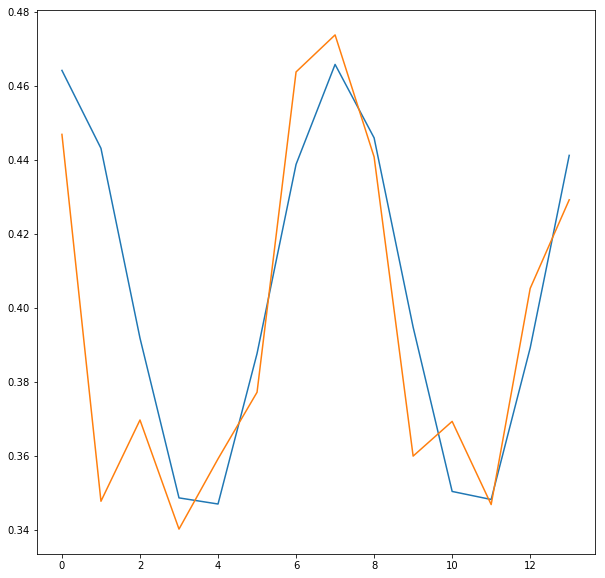

In [25]:
#Score next 14 days
i=3
p_tst = y_pred.eval(feed_dict={x_input: [X_tst[i]], keep_prob: 1})
print(p_tst)
print(y_tst[i])
# Plot for 1 step forecast
plt.plot(p_tst[0])
plt.plot(y_tst[i])
plt.show()  


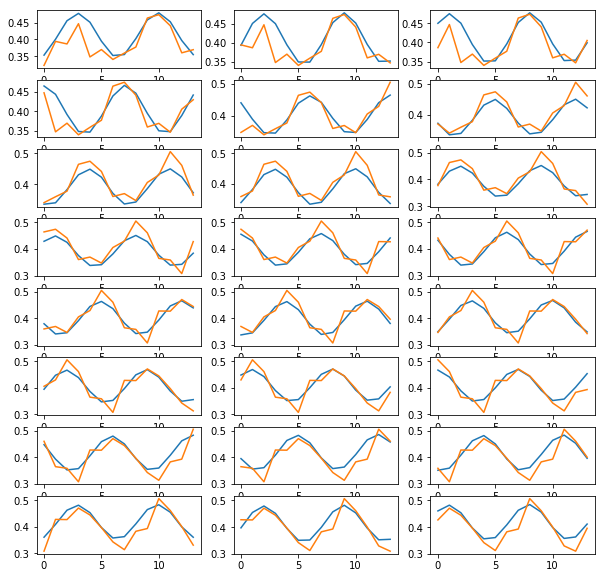

In [26]:
fig = plt.figure()
for i in range(24):
    fig.add_subplot(8,3,i+1)
    p_tst = y_pred.eval(feed_dict={x_input: [X_tst[i]], keep_prob: 1})
    real_vs_pred = np.array([ p_tst[0], y_tst[i]]).T
    plt.plot(real_vs_pred)